In [ ]:
# prompt: import pandas as pd

import pandas as pd
df=pd.read_csv("MSFT.csv")

In [ ]:
# prompt: df\

df.loc[9077]

,9077
date,2022-03-17
open,287.0272
high,289.2977
low,283.1909
close,288.916
volume,30765471


In [ ]:
df=df[['date','close']]
df

,date,close
0,1986-03-13,0.0603
1,1986-03-14,0.0624
2,1986-03-17,0.0635
3,1986-03-18,0.0619
4,1986-03-19,0.0608
...,...,...
9739,2024-11-04,408.4600
9740,2024-11-05,411.4600
9741,2024-11-06,420.1800
9742,2024-11-07,425.4300


In [ ]:
import datetime
def str_to_datetime(s):
    split=s.split('-')
    year,month,day=int(split[0]),int(split[1]),int(split[2])
    return datetime.datetime(year,month,day)
datetime_object=str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [ ]:
df['date']=df['date'].apply(str_to_datetime)
df['date']

<ipython-input-18-32f9bb2bb7fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date']=df['date'].apply(str_to_datetime)


,date
0,1986-03-13
1,1986-03-14
2,1986-03-17
3,1986-03-18
4,1986-03-19
...,...
9739,2024-11-04
9740,2024-11-05
9741,2024-11-06
9742,2024-11-07


In [ ]:
df.index=df.pop('date')
df

,close
date,
1986-03-13,0.0603
1986-03-14,0.0624
1986-03-17,0.0635
1986-03-18,0.0619
1986-03-19,0.0608
...,...
2024-11-04,408.4600
2024-11-05,411.4600
2024-11-06,420.1800


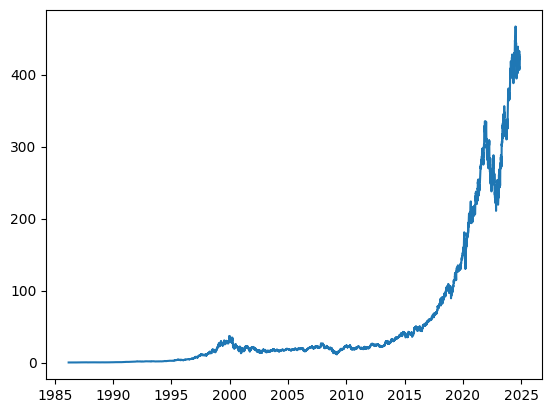

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df.index,df['close'])

In [ ]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,229.0831,230.6266,228.5686,225.5399
1,2021-03-26,230.6266,228.5686,225.5399,229.5588
2,2021-03-29,228.5686,225.5399,229.5588,228.3551
3,2021-03-30,225.5399,229.5588,228.3551,225.0643
4,2021-03-31,229.5588,228.3551,225.0643,228.8696
...,...,...,...,...,...
247,2022-03-17,270.5370,281.0183,288.1037,288.9160
248,2022-03-18,281.0183,288.1037,288.9160,294.0147
249,2022-03-21,288.1037,288.9160,294.0147,292.7719
250,2022-03-22,288.9160,294.0147,292.7719,297.5672


In [ ]:
def windowed_df_to_date_X_Y(windowed_df):
  df_as_np=windowed_df.to_numpy()
  dates=df_as_np[:,0]
  middle_matrix=df_as_np[:,1:-1]
  X=middle_matrix.reshape(len(dates),middle_matrix.shape[1],1)
  Y=df_as_np[:,-1]
  return dates,X.astype(np.float32),Y.astype(np.float32)
dates,X,Y=windowed_df_to_date_X_Y(windowed_df)
dates.shape,X.shape,Y.shape

((252,), (252, 3, 1), (252,))

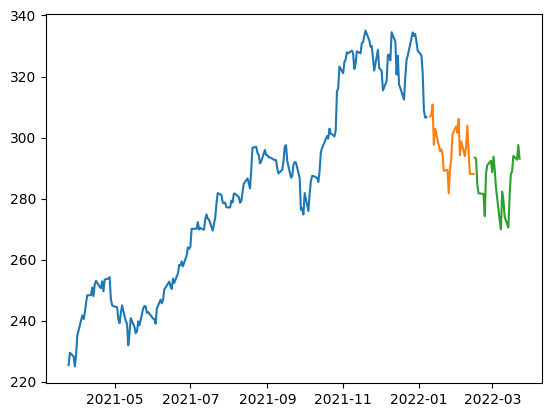

In [ ]:
q_80=int(len(dates)*0.8)
q_90=int(len(dates)*0.9)
dates_train,X_train,Y_train=dates[:q_80],X[:q_80],Y[:q_80]
dates_val,X_val,Y_val=dates[q_80:q_90],X[q_80:q_90],Y[q_80:q_90]
dates_test,X_test,Y_test=dates[q_90:],X[q_90:],Y[q_90:]

plt.plot(dates_train,Y_train)
plt.plot(dates_val,Y_val)
plt.plot(dates_test,Y_test)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model=Sequential([layers.Input((3,1)),
                  layers.LSTM(64),
                  layers.Dense(32,activation='relu'),
                  layers.Dense(32,activation='relu'),
                  layers.Dense(1)])
model.compile(loss='mse',optimizer=Adam(learning_rate=0.001),metrics=['mean_absolute_error'])
model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 80175.8125 - mean_absolute_error: 281.4223 - val_loss: 87962.1016 - val_mean_absolute_error: 296.4989
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 80482.6484 - mean_absolute_error: 281.8506 - val_loss: 87789.8516 - val_mean_absolute_error: 296.2083
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 79296.8438 - mean_absolute_error: 279.7440 - val_loss: 87598.6172 - val_mean_absolute_error: 295.8853
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 80168.9844 - mean_absolute_error: 281.3174 - val_loss: 87350.3125 - val_mean_absolute_error: 295.4654
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 79423.8516 - mean_absolute_error: 279.9729 - val_loss: 86954.5469 - val_mean_absolute_error: 294.7948
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 78741.4766 - mean_absolute_error: 278.7984 - val_loss: 86339.6797 - val_mean_absolute_error: 293.7501
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12m

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


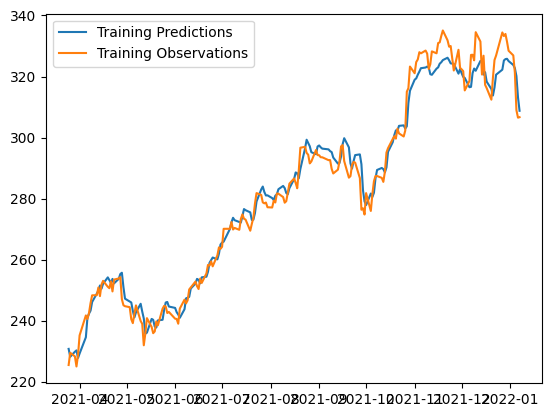

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


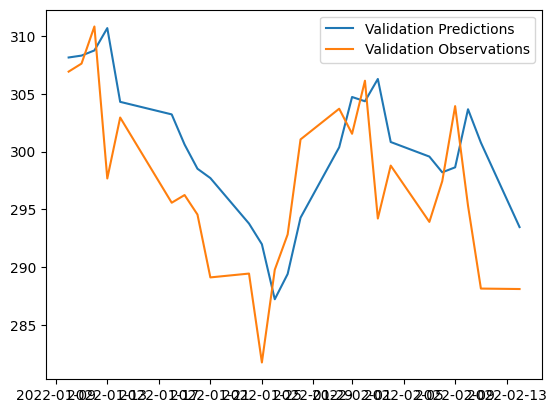

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


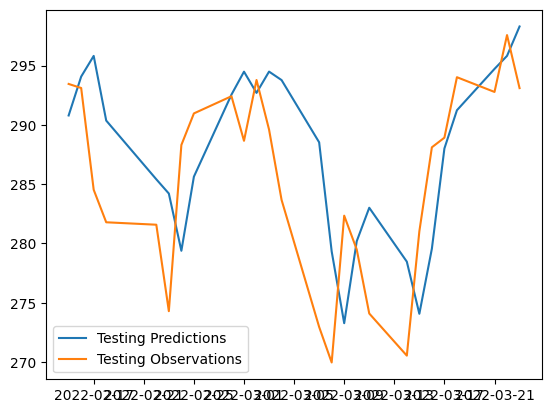

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

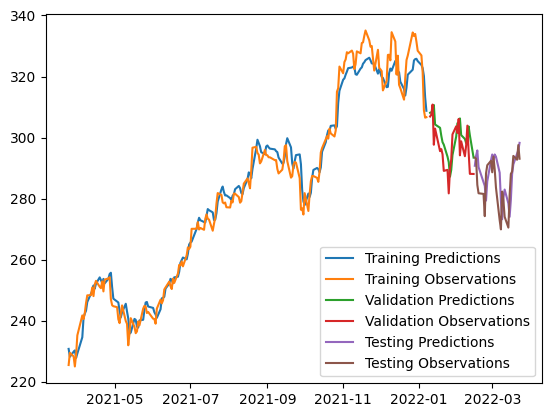

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

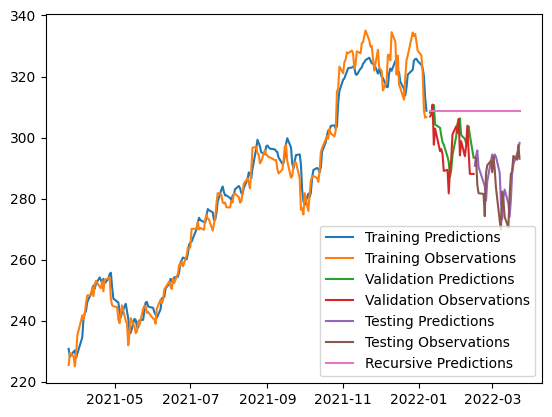

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])